# CNN for task performance comparison

#### Unzip files

In [0]:
# unzip files
import zipfile

UNZIP_NAME = 'files.zip'

with zipfile.ZipFile(UNZIP_NAME, 'r') as zip_ref:
  zip_ref.extractall('.')


## Get data

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#### Import data

In [87]:
#DATA_PATH = '/Users/anthony/Documents/Comp551_Projects/CapNET/data/mnistData.npz'
#DATA_PATH = 'noisy_mnist_data_0-38.npz'
DATA_PATH = 'fashion_mnist_Data.npz'

npzfile = np.load(DATA_PATH)
npzfile.files

['X_train', 'y_train', 'X_test', 'y_test']

#### Unpack - take subset? 

In [88]:
TAKE_SUBSET = True
SUBSET_SIZE = 6000

# Unpack the training and testing datasets
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

# Take subset
if TAKE_SUBSET:
    X_train = X_train[0:SUBSET_SIZE]
    y_train = y_train[0:SUBSET_SIZE]
    
# Expand the dimension of images to signal greyscale
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(6000, 28, 28, 1)
(6000, 10)
(10000, 28, 28, 1)
(10000, 10)


### Check Normalization

In [90]:
SCALE = True

print("Original Feature range: [%f - %f]" % (np.min(X_train),np.max(X_train)))

if SCALE:
  X_train = X_train / np.max(X_train)
  X_test = X_test / np.max(X_test)
  
  print("Scale Feature Ranges:")
  print("[%f - %f]" % (np.min(X_train),np.max(X_train)))
  print("[%f - %f]" % (np.min(X_test),np.max(X_test)))


Original Feature range: [0.000000 - 255.000000]
Scale Feature Ranges:
[0.000000 - 1.000000]
[0.000000 - 1.000000]


## Set up convolutional net

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D
from keras.layers import BatchNormalization
import keras.layers

### Define model(s)

In [0]:
def basic_CNN():
    # Input layer
    x = Input(shape=(28,28,1))
    
    # First convolution
    conv1 = Conv2D(filters=256, kernel_size=9, strides=1,\
                          padding='valid', activation='relu')(x)
    
    # Second convolution (32 capsules * 8 dimensions: 256 individual filters equivalency )
    conv2 = Conv2D(filters=256, kernel_size=9, strides=2,\
                          padding='valid', activation='relu')(conv1)
    
    # Max pooling (instead of dynamic routing)
    pool = MaxPooling2D(pool_size=2, strides=1)(conv2)
    
    # Third convolution (10 capsules * 16 dimension: 160 individual filter equivapency)
    conv3 = Conv2D(filters=160, kernel_size=5, strides=1,\
                          padding='valid', activation='relu')(pool)
    
    # Flatten
    flat = Flatten()(conv3)
    
    # Output layer
    fc = Dense(10, activation='softmax')(flat)    
    
    # Compile model
    model = Model(x, fc)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
  
def reguNormed_CNN():
    # Input layer
    x = Input(shape=(28,28,1))
    
    # First convolution
    conv1 = Conv2D(filters=256, kernel_size=9, strides=1,\
                          padding='valid', activation='relu')(x)
    drop1 = keras.layers.Dropout(0.3)(conv1)
        
    # Second convolution (32 capsules * 8 dimensions: 256 individual filters equivalency )
    conv2 = Conv2D(filters=256, kernel_size=9, strides=2,\
                          padding='valid', activation='relu')(drop1)
    
    # Max pooling (instead of dynamic routing)
    pool = MaxPooling2D(pool_size=2, strides=1)(conv2)
    drop2 = keras.layers.Dropout(0.3)(pool)
        
    # Third convolution (10 capsules * 16 dimension: 160 individual filter equivapency)
    conv3 = Conv2D(filters=160, kernel_size=5, strides=1,\
                          padding='valid', activation='relu')(drop2)
    
 
    # Flatten and batch normalize
    flat = Flatten()(conv3)
    norm = BatchNormalization()(flat)
    
    # Output layer
    out = Dense(10, activation='softmax')(norm)
    
    # Compile model
    model = Model(x, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
    

In [93]:
#model = basic_CNN()
model = reguNormed_CNN()
model.summary()

## TODO: compare the number of parameters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 256)       20992     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 256)         5308672   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 160)         1024160   
__________

### Train model

In [94]:
history = model.fit(X_train, y_train,
                    epochs=35,
                    batch_size=60,
                    shuffle=True,
                    validation_data=(X_test, y_test)
                   )

Train on 6000 samples, validate on 10000 samples
Epoch 1/35
6000/6000 [==============================] - 11s 2ms/step - loss: 0.7879 - acc: 0.7098 - val_loss: 0.7984 - val_acc: 0.7161
Epoch 2/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.5377 - acc: 0.8003 - val_loss: 0.7139 - val_acc: 0.7463
Epoch 3/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.4822 - acc: 0.8223 - val_loss: 0.6355 - val_acc: 0.7931
Epoch 4/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.4256 - acc: 0.8418 - val_loss: 0.5284 - val_acc: 0.7906
Epoch 5/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.3870 - acc: 0.8553 - val_loss: 0.4883 - val_acc: 0.8182
Epoch 6/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.3527 - acc: 0.8663 - val_loss: 0.4766 - val_acc: 0.8241
Epoch 7/35
6000/6000 [==============================] - 10s 2ms/step - loss: 0.3448 - acc: 0.8728 - val_loss: 0.4798 - val_acc: 0.8322
Epoch 

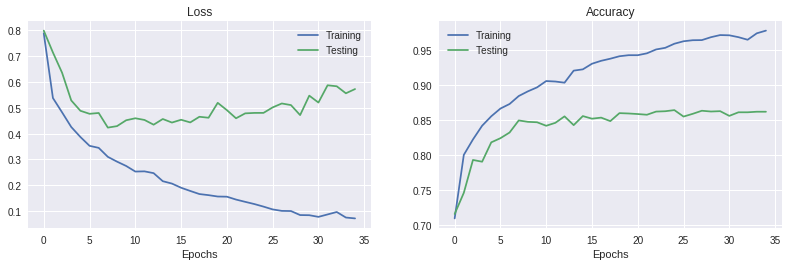

In [95]:
# Plot history
plt.figure(figsize=(13.5,3.8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Testing'])

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Testing'])

plt.show()

#### Save weights and history

In [0]:
SAVE_WEIGHTS = False
MODEL_NAME = 'fashion-mnist_CNN_25Epochs'

if SAVE_WEIGHTS:
  model.save_weights('%s_weights.h5' % MODEL_NAME)


In [0]:
# Save training history
import pickle

SAVE_HISTORY = True

if SAVE_HISTORY:
  pickle.dump( history.history, open('%s_history.pickle'%MODEL_NAME, 'wb') )



## Model Evaluation
### Get test data

In [77]:
# Import files

#TEST_DATA_PATH = 'noisy_mnist_data_0-38.npz'
TEST_DATA_PATH = 'mnistData.npz'

test_npzfile = np.load(TEST_DATA_PATH)
test_npzfile.files

['X_train', 'y_train', 'X_test', 'y_test']

In [78]:
# Unpack the training and testing datasets
new_X_test, new_y_test = test_npzfile['X_test'], test_npzfile['y_test']
    
# Expand the dimension of images to signal greyscale
new_X_test = np.expand_dims(new_X_test, axis=3)

# Check the scaling of the test data
print("Test dataset feature range: [%f - %f]" % (np.min(new_X_test),np.max(new_X_test)))

print(np.shape(new_X_test))
print(np.shape(new_y_test))

Test dataset feature range: [0.000000 - 1.000000]
(10000, 28, 28, 1)
(10000, 10)


### Evaluate model
** On the original test set **

In [98]:
model.evaluate(x = X_test,
               y = y_test,
               verbose=1
              )

10000/10000 [==============================] - 5s 487us/step


[0.5723449234068394, 0.8618]

** On the new test set **

In [86]:
model.evaluate(x = new_X_test,
               y = new_y_test,
               verbose=1
              )

10000/10000 [==============================] - 5s 470us/step


[0.1315754118097954, 0.9803]